In [36]:
import os
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [37]:
def download_and_extract(data_dir='data'):
    os.makedirs(data_dir, exist_ok=True)
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip"
    zip_path = os.path.join(data_dir, "LD2011_2014.txt.zip")
    txt_path = os.path.join(data_dir, "LD2011_2014.txt")
    if not os.path.exists(txt_path):
        r = requests.get(url)
        with open(zip_path,"wb") as f: f.write(r.content)
        with zipfile.ZipFile(zip_path,"r") as z: z.extractall(data_dir)
    return txt_path

def load_daily_aggregate(txt_path, data_dir='data'):
    processed_path = os.path.join(data_dir, "daily_aggregate.pkl")
    if os.path.exists(processed_path):
        return pd.read_pickle(processed_path)
    df = pd.read_csv(txt_path, sep=';', index_col=0, parse_dates=True)
    df = df.replace(',', '.', regex=True).astype(float)
    df['total'] = df.sum(axis=1)
    daily = df[['total']].resample('D').sum()
    daily.to_pickle(processed_path)
    return daily

txt = download_and_extract()
daily = load_daily_aggregate(txt).loc['2011-01-01':'2014-12-31']
daily['t_day'] = (daily.index - daily.index[0]).days


df = daily.loc['2011-01-01':'2013-12-31']

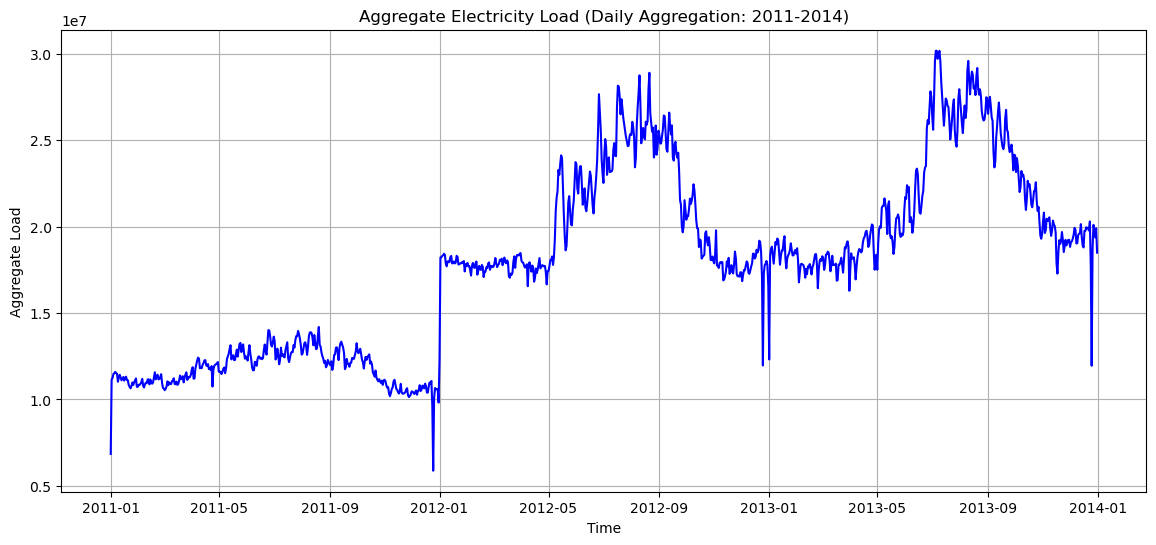

In [38]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['total'], color='blue')
plt.title("Aggregate Electricity Load (Daily Aggregation: 2011-2014)")
plt.xlabel("Time")
plt.ylabel("Aggregate Load")
plt.grid(True)
plt.show()

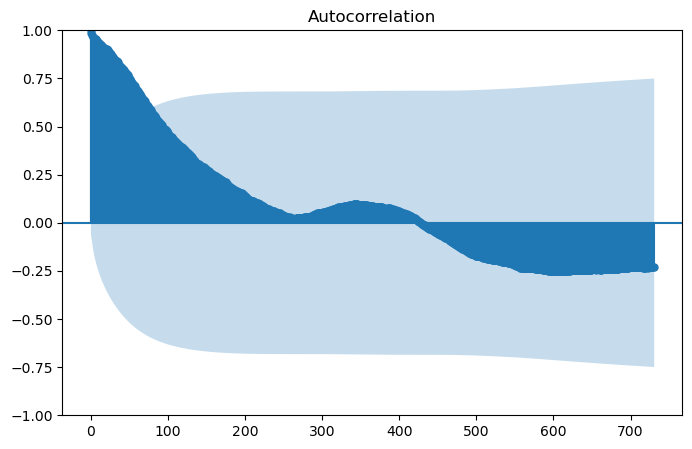

/var/folders/qd/qcmv0_xj6ysfn9j044hp74fc0000gn/T/ipykernel_35731/695327540.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["aggregate_seasonal_diff"] = df["total"] - df["total"].shift(365)


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

series = df["total"].dropna()
fig, ax = plt.subplots(figsize=(8, 5))
plot_acf(series, lags=730, ax=ax)  # statsmodels function
plt.show()

df["aggregate_seasonal_diff"] = df["total"] - df["total"].shift(365)

Top 10 wavelengths (days per cycle):
  - 1096.0 days per cycle → power = 1.40e+16
  - 548.0 days per cycle → power = 6.05e+15
  - 365.3 days per cycle → power = 5.81e+15
  - 182.7 days per cycle → power = 7.29e+14
  - 274.0 days per cycle → power = 3.71e+14
  - 219.2 days per cycle → power = 3.44e+14
  - 156.6 days per cycle → power = 3.08e+14
  - 109.6 days per cycle → power = 2.19e+14
  - 137.0 days per cycle → power = 1.91e+14
  - 57.7 days per cycle → power = 1.30e+14


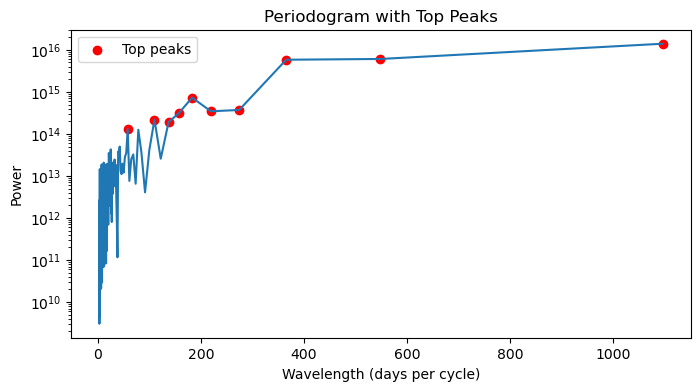

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram

freqs, power = periodogram(df['total'].dropna(), fs=1)

mask       = freqs > 0
freqs_pos  = freqs[mask]
power_pos  = power[mask]

wavelengths = 1.0 / freqs_pos

order = np.argsort(wavelengths)
wavelengths = wavelengths[order]
power_pos = power_pos[order]

top_n = 10
idx_desc = np.argsort(power_pos)[::-1]
top_idx = idx_desc[:top_n]
top_wls = wavelengths[top_idx]
top_powers = power_pos[top_idx]

print(f"Top {top_n} wavelengths (days per cycle):")
for wl, pw in zip(top_wls, top_powers):
    print(f"  - {wl:.1f} days per cycle → power = {pw:.2e}")

plt.figure(figsize=(8,4))
plt.semilogy(wavelengths, power_pos)
plt.scatter(top_wls, top_powers, marker='o', c='red', label='Top peaks')
plt.xlabel('Wavelength (days per cycle)')
plt.ylabel('Power')
plt.title('Periodogram with Top Peaks')
plt.legend()
plt.show()


